In [32]:
#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored


#load dataset
df = pd.read_csv("RADCURE_Clinical_v04_20241219.csv")
df.head()

#convert date columns to datetime
date_columns = ["RT Start", "Date of Death", "Date Local"]
df[date_columns] = df[date_columns].apply(pd.to_datetime, errors='coerce')

#compute survival time(in months)
df["Survival_Time"] = (df["Date of Death"]. fillna(df["Date Local"]) - df["RT Start"]).dt.days /30.0

#Define event status: 1 if patient died, 0 if censored
df["Event"] = np.where(df["Date of Death"].notna(), 1, 0)

#Drop NaN
df = df.dropna(subset=["Survival_Time"])



Log-rank test p-value: 0.07936932024367466
Log-rank test p-value: 0.07936932024367466


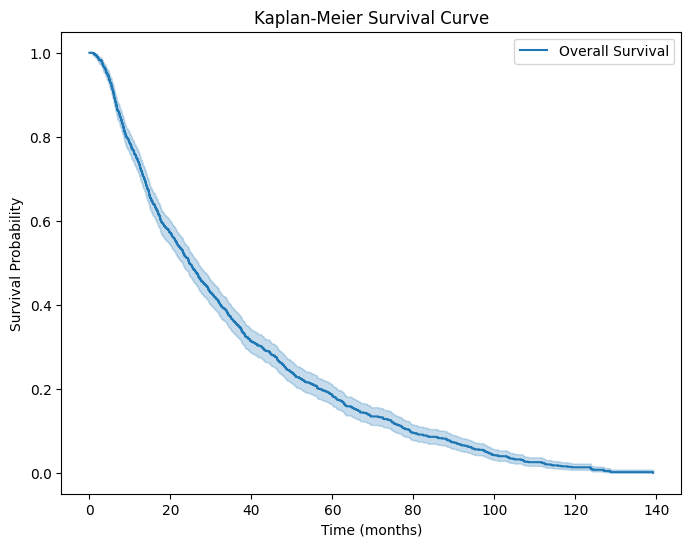

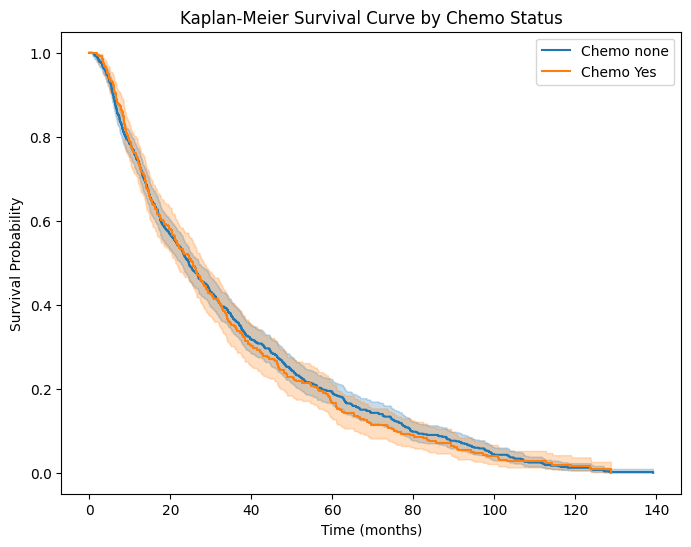

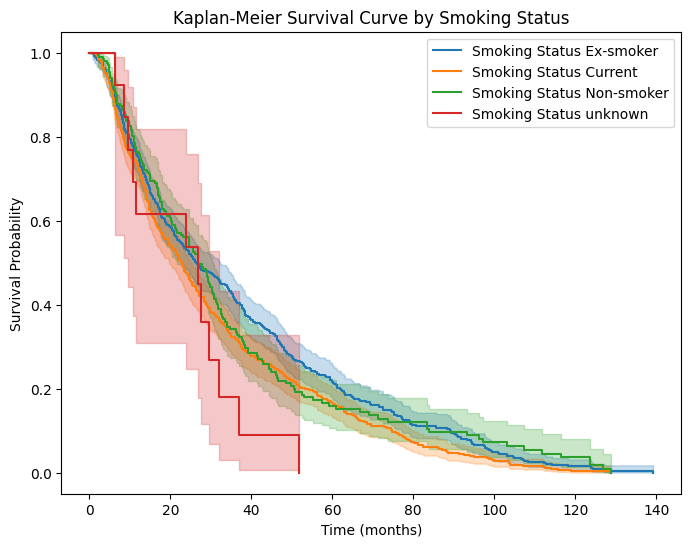

In [38]:
#Kaplan-Meier Survival Curves
#Kaplan-Meier Estimator
kmf = KaplanMeierFitter()
kmf.fit(df["Survival_Time"], df["Event"], label="Overall Survival")

#Plot the survival curve
plt.figure(figsize=(8, 6))
kmf.plot()
plt.title("Kaplan-Meier Survival Curve")
plt.xlabel("Time (months)")
plt.ylabel("Survival Probability")
plt.show

#comparing the Chemo status among groups
chemo_groups = df["Chemo"].dropna(). unique()

plt.figure(figsize=(8, 6))
for group in chemo_groups:
    kmf.fit(df[df["Chemo"] == group]["Survival_Time"],
            df[df["Chemo"] == group]["Event"],
            label=f"Chemo {group}")
    kmf.plot()
plt.title("Kaplan-Meier Survival Curve by Chemo Status")
plt.xlabel("Time (months)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show

#log-rank test
chemo_none = df[df["Smoking Status"] == "Current"]
chemo_yes = df[df["Smoking Status"] == "Non-smoker"]

logrank_test_results = logrank_test(
    chemo_none["Survival_Time"], chemo_yes["Survival_Time"],
    event_observed_A=chemo_none["Event"], event_observed_B=chemo_yes["Event"]
)
print(f"Log-rank test p-value: {logrank_test_results.p_value}")


#comparing the Chemo status among groups
chemo_groups = df["Smoking Status"].dropna(). unique()

plt.figure(figsize=(8, 6))
for group in chemo_groups:
    kmf.fit(df[df["Smoking Status"] == group]["Survival_Time"],
            df[df["Smoking Status"] == group]["Event"],
            label=f"Smoking Status {group}")
    kmf.plot()
plt.title("Kaplan-Meier Survival Curve by Smoking Status")
plt.xlabel("Time (months)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show

#log-rank test
current_smoker= df[df["Smoking Status"] == "Current"]
non_smoker = df[df["Smoking Status"] == "Non-smoker"]

logrank_test_results = logrank_test(
    current_smoker["Survival_Time"], non_smoker["Survival_Time"],
    event_observed_A=current_smoker["Event"], event_observed_B=non_smoker["Event"]
)
print(f"Log-rank test p-value: {logrank_test_results.p_value}")



                     Results: PHReg
Model:                 PH Reg         Sample size:  1194
Dependent variable:    Survival_Time  Num. events:  1194
Ties:                  Breslow                          
--------------------------------------------------------
     log HR log HR SE   HR     t    P>|t|  [0.025 0.975]
--------------------------------------------------------
Age  0.0050    0.0028 1.0051 1.8251 0.0680 0.9996 1.0105
Dose 0.0262    0.0055 1.0265 4.7629 0.0000 1.0155 1.0377
Confidence intervals are for the hazard ratios


<function matplotlib.pyplot.show(close=None, block=None)>

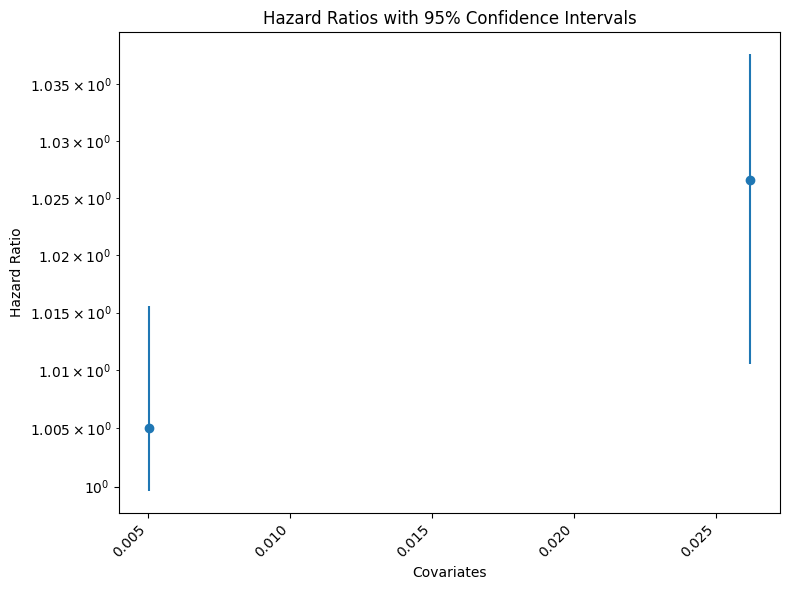

In [48]:
#Cox Proportional Hazards Model
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
# #Select covariates
covariates = ["Age", "Dose"]
df_cox = df[["Survival_Time", "Event"] + covariates].dropna()

#Encode categorical variables
df_cox = pd.get_dummies(df_cox, drop_first=True)


#Fit Cox Model using statsmodels
cph_model = smf.phreg("Survival_Time ~ Age + Dose", data=df_cox, duartion_col="Survival_Time", event_col="Event")
results = cph_model.fit()

#ouput the model summary
print(results.summary())

#Extract the coefficients and confidence intervals
hr = pd.Series(np.exp(results.params), index=results.params)
hr_conf_int = results.conf_int()
#
#calculate the error bars
lower_bound = np.exp(hr_conf_int[0])
upper_bound = np.exp(hr_conf_int[1])

#Ensure no negative error values
yerr_lower = hr - lower_bound
yerr_upper = upper_bound - hr

#Plot hazard ratios with the confidence intervals
fig, ax = plt.subplots(figsize=(8, 6))

#Plot hazard ratios and confidence intervals
ax.errorbar(hr.index, hr, yerr=[yerr_lower, yerr_upper ], fmt='o', label='Hazard Ratio')
ax.set_xlabel('Covariates')
ax.set_ylabel("Hazard Ratio")
ax.set_title('Hazard Ratios with 95% Confidence Intervals')
ax.set_yscale('log')
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show





[('Event', '?'), ('Time', '<f8')]
[( True, 26.43333333) ( True, 27.33333333) (False,  6.5       )
 ( True, 34.36666667) ( True,  7.93333333)]
Random Survival Forest C-index: 0.5311703314212874


<function matplotlib.pyplot.show(close=None, block=None)>

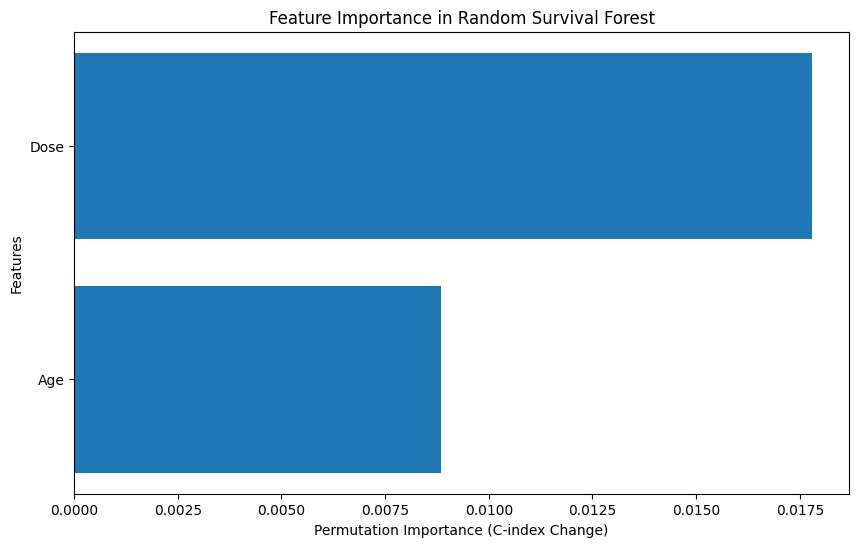

In [ ]:
from sksurv.datasets import get_x_y
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sksurv.util import Surv
from sklearn.inspection import permutation_importance

# #Prepare dataset
df_rsf = df[["Survival_Time", "Event"] + covariates].dropna()

#Encode categorical variables
for col in covariates:
    if df_rsf[col].dtype == "object":
       df_rsf[col] = LabelEncoder().fit_transform(df_rsf[col])

#convert survival data format
y = np.array(list(zip(df_rsf["Event"], df_rsf["Survival_Time"])), dtype=[("Event", "?"), ("Time", "<f8")])
X = df_rsf.drop(columns=["Survival_Time", "Event"])

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#fit RSF model
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, random_state=42)
rsf.fit(X_train, y_train)

print(y_test.dtype)
print(y_test[:5])

#Evaluate model performance
c_index = rsf.score(X_test, y_test)
print(f"Random Survival Forest C-index: {c_index}")

# #variable importance
def c_index_scorer(estimator, X, y):
      event, time = y["Event"], y["Time"]
      risk_scores = estimator.predict(X)
#compute C-index and extract only the first value
      c_index = concordance_index_censored(event, time, risk_scores)[0]
      return c_index
#compute permutation importance
perm_importance = permutation_importance(
rsf, X_test, y_test, n_repeats=10, random_state=42, scoring=c_index_scorer
)
#sort feature importances
sorted_idx = np.argsort(perm_importance.importances_mean)

#Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.title("Feature Importance in Random Survival Forest")
plt.xlabel("Permutation Importance (C-index Change)")
plt.ylabel("Features")
plt.show




In [ ]:
#Comparing models
from lifelines import concordance_index

#kaplan-meier
c_index_km = concordance_index(df["SurvivalTime"], kmf.predict(df['Survival_Time']))
print(f'kaplan-Meier c-index: {c_index_km}')

#Cox proportional hazard
cox_c_index = concordance_index(df_cox["Survival_time"]), cph_model.predict_partial_hazard(df_cox(covariates))
print(f"Cox Proportional Hazards c-index: {c_index_cox}")

#Random Survival forest
c_index = rsf.score(X_test, y_test)
print(f"Random Survival Forest C-index: {c_index}")
